# Free Energies
While it is technically possible to calculate free energies from molecular dynamics calculation based on the energies and forces calculated from DFT calculation, this is typically done with machine learning interatomic potentials, which are discussed in the next lecture. A more common approach to calculate free energies with DFT is using the harmonic or quasi-harmonic approximation. 

In the following tutorial the harmonic approximation is discussed using the [SPHInX](https://sxrepo.mpie.de) DFT code in combination with [phonopy](https://phonopy.github.io/phonopy/) and the [pyiron.org](https://pyiron.org) workflow framework. The `phonopy` package is included in `pyiron_atomistics` so no additional installation is required.  In analogy to the other tutorials, the fourth tutorial starts by importing the `Project` object in addition to `matplotlib`. 

In [1]:
import matplotlib.pyplot as plt
from pyiron_atomistics import Project

## Calculation
As a first step the `phonons` folder is created using the `Project` object. To have a clean start all calculations in this folder are removed using the `remove_jobs()` function. This is typically not necessary, but it is a helpful command to restart fresh.

In [2]:
pr = Project("phonons")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-03 17:17:02,551 - pyiron_log - WARNING - Could not remove job with ID 1925 


Based on a previous tutorial, it is recommended to adjust the lattice constant for Aluminium from the experimental suggestion of `a=4.04` to `a=4.09`. This can depend on the choice of pseudo potential resulting in an overall difference between the prediction from DFT and the measurements from experiment. 

In [3]:
structure_bulk = pr.create.structure.ase.bulk("Al", a=4.09, cubic=True)

As discussed in the third tutorial, it is recommended to test the convergence of any property calculated with DFT. Still in the interest of time, only a single phonon calculation is discussed in this tutorial and the convergence tests are left as an exercise. 

The SPHInX calculation is again configured using the same functionality as introduced in the previous tutorials. The atomistic structure is assigned to the `structure` property, the k-point mesh is set using the `set_kpoints()` function in analogy to the `set_encut()` function for the planewave energy cut-off. Finally, the computational resources in terms of the number of CPU cores for the calculation are specified by setting the `cores` property of the `server` object. 

In [4]:
job_Al_small = pr.create.job.Sphinx("spx")
job_Al_small.structure = structure_bulk
job_Al_small.set_kpoints([2,2,2])
job_Al_small.set_encut(400.0)
job_Al_small.server.cores = 1

The `PhonopyJob` is the pyiron internal interface to the `phonopy` python package. It orchestrates the calculation of multiple DFT calculation just like the `Murnaghan` object in the previous tutorial. So just like before the SPHInX calculation is assigned to the `PhonopyJob` using the `ref_job` property. Afterwards the setup the `run()` function is called to trigger the execution. 

In [5]:
job_phonopy = pr.create.job.PhonopyJob("phono")
job_phonopy.ref_job = job_Al_small
job_phonopy.run()

The job phono was saved and received the ID: 1945


/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['rotations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['translations']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-pac

The job spx_0 was saved and received the ID: 1957


## Analysis
After the completion of the calculation, a number of poperties are automatically computed. These can be directly accessed from the `job` object. For more details on the internal functionality the interested reader is referred to the [phonopy](https://phonopy.github.io/phonopy/) documentaiton. 

As a first step the Phonon Density of States (DOS) is plotted over the frequency with the `plot_dos()` function:

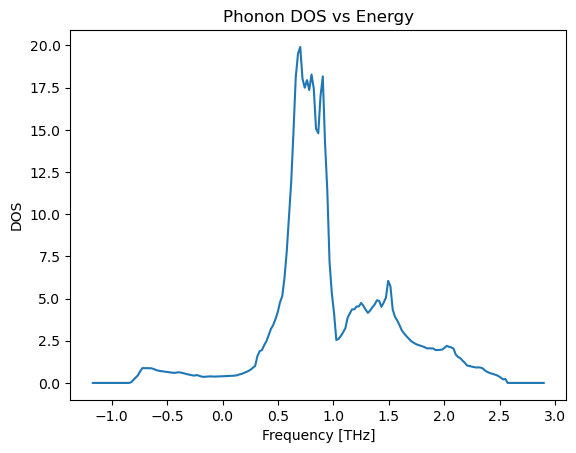

In [6]:
job_phonopy.plot_dos()

The density of states is the result of the summation of the individual bands of the band structure which can also be plotted using the `plot_band_structure()` function. The imaginary frequences highlight that this calculation is not converged, this is most likely related to the choice of lattice constant, which is not sufficiently equilibrated. 

/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/home/janssen/mambaforge/lib/python3.12/site-pack

<Axes: title={'center': 'Bandstructure'}, xlabel='Bandpath', ylabel='Frequency [THz]'>

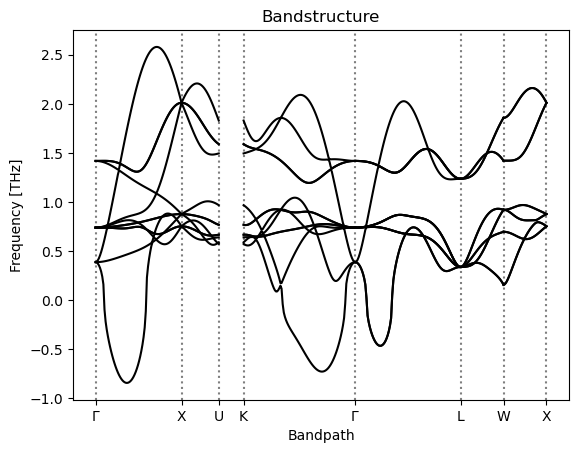

In [7]:
job_phonopy.plot_band_structure()

Finally, beyond the band structure the same phonon calculation can also be used to calculate the free energy. By default phonopy uses the quantum mechanical harmonic oscillator with the frequencies calculated from the band structure calculation. In `pyiron` this is achieved using the `get_thermal_properties()` function which returns a thermodynamic object which contains the temperatures, free energies and heat capacity.

Text(0.5, 0, 'Temperature (K)')

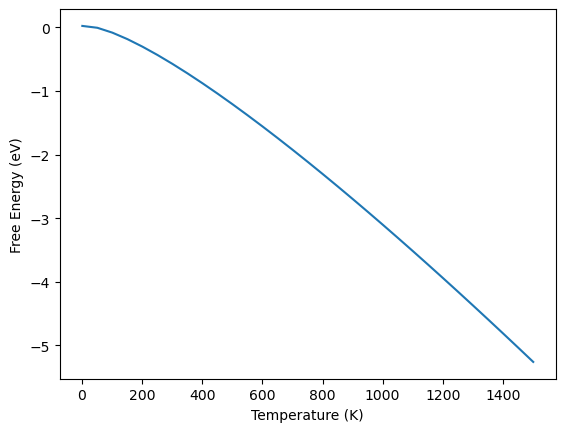

In [8]:
thermo = job_phonopy.get_thermal_properties()
plt.plot(thermo.temperatures, thermo.free_energies)
plt.ylabel("Free Energy (eV)")
plt.xlabel("Temperature (K)")

Text(0.5, 0, 'Temperature (K)')

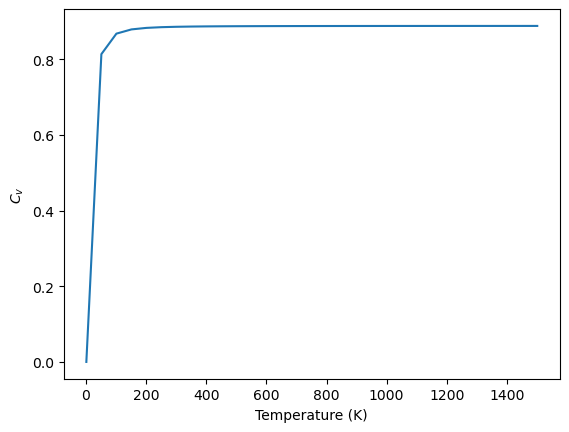

In [9]:
plt.plot(thermo.temperatures, thermo.cv/ len(structure_bulk.repeat([3,3,3])))
plt.ylabel("$C_v$")
plt.xlabel("Temperature (K)")

## Conclusion

In summary, this fourth tutorial concludes the brief introduction into DFT and especially computing thermodynamic properties with DFT precision. 